In [17]:
import numpy as np
import cv2

from matplotlib import pyplot as plt

import scipy.ndimage.morphology as m
from sklearn.cluster import KMeans
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
%matplotlib inline


In [18]:
def getColorSpaces(image):
    rgb = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    return rgb,gray

def getImageDimnesion(image):
    height,width = image.shape[:2]
    
    return height,width

def showImage(image,title,cmap):
    plt.imshow(image,cmap=cmap)
    plt.axis('off')
    plt.title(title)

def splitRGBChannels(image):
  red, green, blue= cv2.split(img)
  
  return red, green, blue

def getBinaryImage(gray):
    ret,thresh= cv2.threshold(gray,127,255,cv2.THRESH_BINARY)
    return thresh
 
def cropBorder(image,dx=20,dy=20):
    h,w=getImageDimnesion(image)    
    im=image.copy()
    im = im[dy:h-dy,dx:w-dx]
    
    return im

## Question 1: Skeletonization

In [19]:
 
def getSkeletonizedImage(binary):
    h1 = np.array([[0, 0, 0],[0, 1, 0],[1, 1, 1]]) 
    m1 = np.array([[1, 1, 1],[0, 0, 0],[0, 0, 0]]) 
    h2 = np.array([[0, 0, 0],[1, 1, 0],[0, 1, 0]]) 
    m2 = np.array([[0, 1, 1],[0, 0, 1],[0, 0, 0]])    
    hit_list = [] 
    miss_list = []
    for k in range(4): 
        hit_list.append(np.rot90(h1, k))
        hit_list.append(np.rot90(h2, k))
        miss_list.append(np.rot90(m1, k))
        miss_list.append(np.rot90(m2, k))    
    binary = binary.copy()
    while True:
        last = binary
        for hit, miss in zip(hit_list, miss_list): 
            hm = m.binary_hit_or_miss(binary, hit, miss) 
            binary = np.logical_and(binary, np.logical_not(hm))             
        if np.all(binary == last):  
            break
    return binary

In [20]:
#Kernel sized hit or miss status
def getHitMissStatus(binary_image,kernel):

    h,w = binary_image.shape
    for i in range(h):
        for j in range(w):
            if kernel[i,j]!=-1 and binary_image[i,j]!=kernel[i,j]:
                return False
    return True

def ConvolveHitMiss(binary_image,kernel):
    new_binary_image = binary_image.copy()
    h,w = new_binary_image.shape
    for i in range(1,h-1):
        for j in range(1,w-1):
            if getHitMissStatus(binary_image[i-1:i+2,j-1:j+2],kernel):
                new_binary_image[i,j] = 0    
    return new_binary_image 

def getSkeletonizedbinary_Custom(binary_image,threshold=1):
    S1 = np.array([
            [0,0,0],
            [-1,1,-1],
            [1,1,1]])
    S2 = np.array([
            [-1,0,0],
            [1,1,0],
            [-1,1,-1]])
    bin_binary_image = (binary_image < 127).astype(np.uint8)

    while True:
        new_binary_image = bin_binary_image
        for i in range(4):
            new_binary_image = ConvolveHitMiss(new_binary_image,S1)    
            new_binary_image = ConvolveHitMiss(new_binary_image,S2)    
            S1 = np.rot90(S1)
            S2 = np.rot90(S2)  
        diff = np.mean(np.abs(new_binary_image-bin_binary_image))
        if diff <= threshold: 
            break
        else:
            bin_binary_image = new_binary_image
    return new_binary_image

def getSkeletonizedbinary_Custom2(binary_image,threshold=1):
    S1 = np.array([
            [0,0,0],
            [-1,1,-1],
            [1,1,1]])
    S2 = np.array([
            [-1,0,0],
            [1,1,0],
            [-1,1,-1]])
    bin_binary_image = (binary_image < 127).astype(np.uint8)
    
    S1_list = [] 
    S2_list = []
    
    for k in range(4):        
        S1_list.append(np.rot90(S1, k))
        S2_list.append(np.rot90(S2, k))

    while True:
        new_binary_image = bin_binary_image
        for s1,s2 in zip(S1_list,S2_list):
            new_binary_image = ConvolveHitMiss(new_binary_image,s1)    
            new_binary_image = ConvolveHitMiss(new_binary_image,s2)    

        diff = np.mean(np.abs(new_binary_image-bin_binary_image))
        print('Diff :',diff)
        if diff <= threshold: 
            break
        else:
            bin_binary_image = new_binary_image
    return new_binary_image

In [22]:
img_path= r'./input_data/fingerprint.jpg'
img = cv2.imread(img_path)
rgb,gray=getColorSpaces(img)

plt.figure(figsize=(12, 12))

plt.subplot(3,2,1) 
plt.axis('off')
plt.title('Original') 
plt.imshow(gray,cmap='gray')

binary=getBinaryImage(gray)
img_not = cv2.bitwise_not(binary)
skeliton = getSkeletonizedImage(img_not)

plt.subplot(3,2,2) 
plt.axis('off')
plt.title('Skeleton Image')
plt.imshow(skeliton,cmap='gray')

skeleton_image = getSkeletonizedbinary_Custom2(gray)   

plt.subplot(3,2,4) 
plt.axis('off')
plt.title('Skeleton Image-Custom')
plt.imshow(skeleton_image,cmap='gray')

error: OpenCV(3.4.2) c:\projects\opencv-python\opencv\modules\imgproc\src\color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'cv::CvtHelper<struct cv::Set<3,4,-1>,struct cv::Set<3,4,-1>,struct cv::Set<0,2,5>,2>::CvtHelper'


In [11]:
#https://stackoverflow.com/questions/50899692/most-dominant-color-in-rgb-image-opencv-numpy-python
def getTopColors(im,num_colors=6):
    #Get color frequnecies
    color, colorcnt = np.unique(im.reshape(-1, im.shape[2]), axis=0, return_counts=True);
    #Sort the occarnces in reverse order to get top n-indices
    indices=(-colorcnt).argsort()[:6]
#    print(indices)
    
    bg_color=color[indices[0]]
    top_colors=[]
    #Most dominant color is background color,which is not text, threfore remove this item from the list
    # and consider only top 5 colors
    for idx in indices[1:]:
        top_colors.append(color[idx])
    
    return np.array(top_colors),bg_color

In [15]:

def getColoredText(im,color,bg_color):    
    h,w = getImageDimnesion(img)
    mask = im.copy()
    
    for i in range(h):
        for j in range(w):
            if not np.array_equal(im[i,j,:],color):
                mask[i,j] = bg_color
    return  mask         


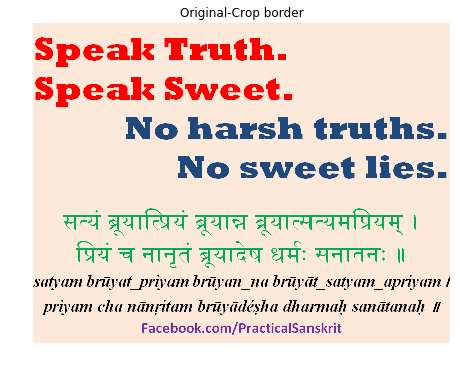

In [16]:
img_path=r'C:/SAI/IIIT/2019_Monsoon/DIP/Assignment4/input_data/fbpost.png'
img = cv2.imread(img_path)
img=cropBorder(img,20,20)

rgb,gray=getColorSpaces(img)

height,width=getImageDimnesion(img)

binary=getBinaryImage(gray)

plt.figure(figsize=(20, 20))

plt.subplot(3,2,1) 
plt.axis('off')
plt.title('Original-Crop border') 
plt.imshow(rgb)

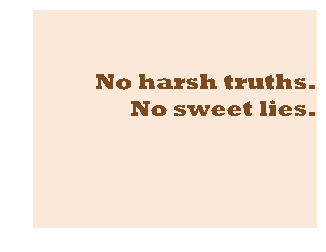

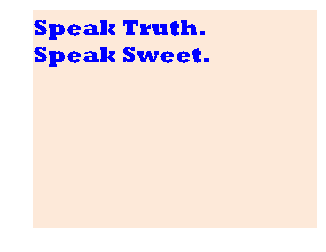

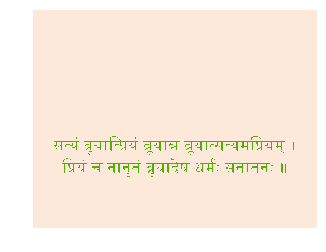

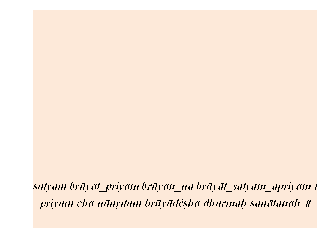

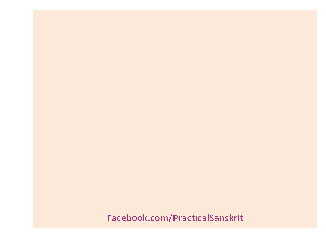

In [14]:
im=rgb.copy()
top_colors,bg_color=getTopColors(im)
#print(top_colors)

text_images = []
for color in top_colors:
    mask=getColoredText(im,color,bg_color)
    text_images.append(mask)

for img in text_images:
    plt.figure()
    plt.axis('off')
    plt.imshow(img)
